# Model fit

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import csv
from scipy.stats import spearmanr

## Model parameters

In [3]:
countries = ['us','de','dk','fr','it','nl','se','sp']
df = pd.read_pickle('../estimation/output/params_ref_us.pkl')
table = df.loc[:,'value'].to_frame()
table.columns = ['us']

for c in countries: 
	df = pd.read_pickle('../estimation/output/params_ref_'+c+'.pkl')
	table[c] = df.loc[:,'value']
table

,us,de,dk,fr,it,nl,se,sp
name,,,,,,,,
sigma,2.101034,2.101034,2.101034,2.101034,2.101034,2.101034,2.101034,2.101034
beta,0.970000,0.970000,0.970000,0.970000,0.970000,0.970000,0.970000,0.970000
phi,0.282108,0.282108,0.282108,0.282108,0.282108,0.282108,0.282108,0.282108
psi,0.136652,0.136652,0.136652,0.136652,0.136652,0.136652,0.136652,0.136652
delta_h1,-1.021047,-1.297368,-1.620886,-0.989299,-0.796356,-1.231644,-1.419716,0.176934
delta_h2,3.430393,4.111966,4.265841,3.769468,3.933223,3.955199,4.317404,3.519121
eta,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
tfp,1.000000,1.022368,1.259887,0.937066,0.676091,1.039062,0.805936,0.837693
price,1.000000,0.835118,0.887434,0.603227,0.606923,0.648879,0.883980,0.851795


## Simulated Moments

In [3]:
# loading results from estimation
momsim = pd.read_pickle('../output_JPE/momsim.pkl')
momsim

,de,dk,fr,it,nl,se,sp,us
s,0.102719,0.090447,0.103340,0.082716,0.088693,0.086432,0.077696,0.143017
tgood,0.982216,0.986061,0.977321,0.980108,0.981542,0.986579,0.967758,0.970159
tbad,0.406540,0.501798,0.506607,0.336872,0.538995,0.474097,0.469313,0.256270
g2,1.034320,1.012335,1.053734,1.026696,1.042717,1.007033,1.085283,1.135900
g3,1.057924,1.020690,1.076606,1.048267,1.057519,1.012481,1.105033,1.221975
g4,1.070411,1.027649,1.080306,1.071815,1.059616,1.018795,1.114558,1.270962
y,0.828224,0.900450,0.733563,0.737428,0.856601,0.806204,0.642308,1.000000
h,0.958089,0.972972,0.957152,0.944244,0.966888,0.972471,0.935716,0.895701


## Targeted moments

In [4]:
countries = ['de','dk','fr','it','nl','se','sp','us']
moments = ['s', 'tgood', 'tbad', 'g2','g3','g4','y','h']
# Estimated moments
emomT_de = [0.1022855, 0.97414118, 0.33089325, 1.0161546, 1.0691098, 1.0758906, 0.8301558557492001,0];
emomT_dk = [0.0906295, 0.97940569, 0.34295961, 1.0869576, 1.0779691, 1.0797791, 0.8982050373873612,0];
emomT_fr = [0.10357350000000001, 0.97445468, 0.3138074, 1.0200051, 1.0608238, 1.0949601, 0.7352641707913572,0];
emomT_it = [0.08108950000000001, 0.9726352, 0.31910557, 1.0347792, 1.0110466, 1.0345493, 0.7399708689473027,0];
emomT_nl = [0.08828149999999998, 0.97351987, 0.47384099, 1.023182, 1.0276797, 1.0165831, 0.872561963669148,0];
emomT_se = [0.085785, 0.97275458, 0.29617631, 1.0512416, 1.0572071, 1.0707381, 0.7979621824232888,0];
emomT_sp = [0.07812250000000001, 0.96483865, 0.34919192, 1.0376513, 0.98119098, 1.0486931, 0.6402592229336116,0];
emomT_us = [0.144225, 0.96204934, 0.20680013, 1.170375, 1.2140929, 1.269144, 1,0];
# Computation of h
Ptrans     = np.array([[emomT_de[1], 1-emomT_de[1]], [emomT_de[2], 1-emomT_de[2]]])
Stath      = np.linalg.matrix_power(Ptrans, 1000)
emomT_de[7] = Stath[0,0]
Ptrans     = np.array([[emomT_dk[1], 1-emomT_dk[1]], [emomT_dk[2], 1-emomT_dk[2]]])
Stath      = np.linalg.matrix_power(Ptrans, 1000)
emomT_dk[7] = Stath[0,0]
Ptrans     = np.array([[emomT_fr[1], 1-emomT_fr[1]], [emomT_fr[2], 1-emomT_fr[2]]])
Stath      = np.linalg.matrix_power(Ptrans, 1000)
emomT_fr[7] = Stath[0,0]
Ptrans     = np.array([[emomT_it[1], 1-emomT_it[1]], [emomT_it[2], 1-emomT_it[2]]])
Stath      = np.linalg.matrix_power(Ptrans, 1000)
emomT_it[7] = Stath[0,0]
Ptrans     = np.array([[emomT_nl[1], 1-emomT_nl[1]], [emomT_nl[2], 1-emomT_nl[2]]])
Stath      = np.linalg.matrix_power(Ptrans, 1000)
emomT_nl[7] = Stath[0,0]
Ptrans     = np.array([[emomT_se[1], 1-emomT_se[1]], [emomT_se[2], 1-emomT_se[2]]])
Stath      = np.linalg.matrix_power(Ptrans, 1000)
emomT_se[7] = Stath[0,0]
Ptrans     = np.array([[emomT_sp[1], 1-emomT_sp[1]], [emomT_sp[2], 1-emomT_sp[2]]])
Stath      = np.linalg.matrix_power(Ptrans, 1000)
emomT_sp[7] = Stath[0,0]
Ptrans     = np.array([[emomT_us[1], 1-emomT_us[1]], [emomT_us[2], 1-emomT_us[2]]])
Stath      = np.linalg.matrix_power(Ptrans, 1000)
emomT_us[7] = Stath[0,0]
# Table of results
pmomT = np.array((emomT_de,emomT_dk,emomT_fr,emomT_it,emomT_nl,emomT_se,emomT_sp,emomT_us))
pmomT = pmomT.T
momsimT = pd.DataFrame(index=moments,columns=countries)
momsimT.loc[:,'de']    = pmomT[:,0]
momsimT.loc[:,'dk']    = pmomT[:,1]
momsimT.loc[:,'fr']    = pmomT[:,2]
momsimT.loc[:,'it']    = pmomT[:,3]
momsimT.loc[:,'nl']    = pmomT[:,4]
momsimT.loc[:,'se']    = pmomT[:,5]
momsimT.loc[:,'sp']    = pmomT[:,6]
momsimT.loc[:,'us']    = pmomT[:,7]
momsimT

,de,dk,fr,it,nl,se,sp,us
s,0.102286,0.090630,0.103574,0.081090,0.088281,0.085785,0.078123,0.144225
tgood,0.974141,0.979406,0.974455,0.972635,0.973520,0.972755,0.964839,0.962049
tbad,0.330893,0.342960,0.313807,0.319106,0.473841,0.296176,0.349192,0.206800
g2,1.016155,1.086958,1.020005,1.034779,1.023182,1.051242,1.037651,1.170375
g3,1.069110,1.077969,1.060824,1.011047,1.027680,1.057207,0.981191,1.214093
g4,1.075891,1.079779,1.094960,1.034549,1.016583,1.070738,1.048693,1.269144
y,0.830156,0.898205,0.735264,0.739971,0.872562,0.797962,0.640259,1.000000
h,0.927516,0.943353,0.924723,0.921018,0.947074,0.915759,0.908518,0.844942


## Figures of the fit

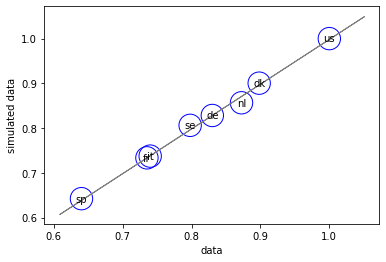

In [5]:
plt.figure()
plt.scatter(momsimT.loc['y'],momsim.loc['y']/momsim.loc['y','us'],facecolors='none', edgecolors='b',s=500.0)
xx1 = np.amin([np.amin(momsim.loc['y']/momsim.loc['y','us']),np.amin(momsimT.loc['y'])])-0.05*np.amin([np.amin(momsim.loc['y']/momsim.loc['y','us']),np.amin(momsimT.loc['y'])])
xx2 = np.amax([np.amax(momsim.loc['y']/momsim.loc['y','us']),np.amax(momsimT.loc['y'])])+0.05*np.amax([np.amax(momsim.loc['y']/momsim.loc['y','us']),np.amax(momsimT.loc['y'])])
xx = np.linspace(xx1,xx2,20)
plt.fill_between(xx, xx-.00, xx+.00, color='grey')#, alpha='0.5')
plt.xlabel('data')
plt.ylabel('simulated data')
for x,y,z in zip(momsimT.loc['y'],momsim.loc['y']/momsim.loc['y','us'],countries):
    plt.annotate(z,xy=(x, y),horizontalalignment='center', verticalalignment='center')
#plt.savefig('../figures_JPE/yTyus.eps',dpi=600)

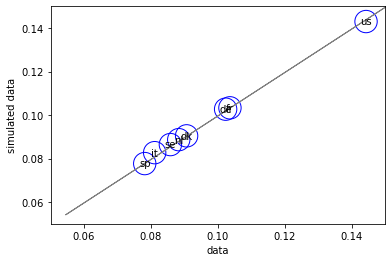

In [6]:
plt.figure()
plt.scatter(momsimT.loc['s'],momsim.loc['s'],facecolors='none', edgecolors='b',s=500.0)
xx1 = np.amin([np.amin(momsim.loc['s']),np.amin(momsimT.loc['s'])])-0.3*np.amin([np.amin(momsim.loc['s']),np.amin(momsimT.loc['s'])])
xx2 = np.amax([np.amax(momsim.loc['s']),np.amax(momsimT.loc['s'])])+0.1*np.amax([np.amax(momsim.loc['s']),np.amax(momsimT.loc['s'])])
xx = np.linspace(xx1,xx2,20)
plt.fill_between(xx, xx-.00, xx+.00, color='grey')#, alpha='0.5')
plt.xlabel('data')
plt.ylabel('simulated data')
for x,y,z in zip(momsimT.loc['s'],momsim.loc['s'],countries):
    plt.annotate(z,xy=(x, y),horizontalalignment='center', verticalalignment='center')
plt.ylim([.05, .15])
plt.xlim([.05, .15])
plt.show()
#plt.savefig('../figures_JPE/share_s.eps',dpi=600)

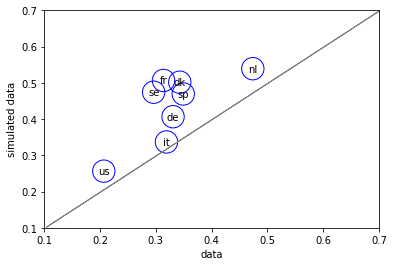

In [7]:
ssize = .5
plt.figure()
plt.scatter(momsimT.loc['tbad'],momsim.loc['tbad'],facecolors='none', edgecolors='b',s=500.0)
xx1 = np.amin([np.amin(momsim.loc['tbad']),np.amin(momsimT.loc['tbad'])])-ssize*np.amin([np.amin(momsim.loc['tbad']),np.amin(momsimT.loc['tbad'])])
xx2 = np.amax([np.amax(momsim.loc['tbad']),np.amax(momsimT.loc['tbad'])])+ssize*np.amax([np.amax(momsim.loc['tbad']),np.amax(momsimT.loc['tbad'])])
xx = np.linspace(xx1,xx2,20)
plt.fill_between(xx, xx-.00, xx+.00, color='grey')#, alpha='0.5')
plt.xlabel('data')
plt.ylabel('simulated data')
for x,y,z in zip(momsimT.loc['tbad'],momsim.loc['tbad'],countries):
    plt.annotate(z,xy=(x, y),horizontalalignment='center', verticalalignment='center')
plt.ylim([.1, .7])
plt.xlim([.1, .7])
plt.show()
#plt.savefig('../figures_JPE/bTg.eps',dpi=600)

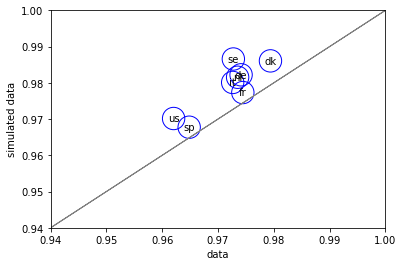

In [8]:
ssize = .05
plt.figure()
plt.scatter(momsimT.loc['tgood'],momsim.loc['tgood'],facecolors='none', edgecolors='b',s=500.0)
xx1 = np.amin([np.amin(momsim.loc['tgood']),np.amin(momsimT.loc['tgood'])])-ssize*np.amin([np.amin(momsim.loc['tgood']),np.amin(momsimT.loc['tgood'])])
xx2 = np.amax([np.amax(momsim.loc['tgood']),np.amax(momsimT.loc['tgood'])])+ssize*np.amax([np.amax(momsim.loc['tgood']),np.amax(momsimT.loc['tgood'])])
xx = np.linspace(xx1,xx2,20)
plt.fill_between(xx, xx-.00, xx+.00, color='grey')#, alpha='0.5')
plt.xlabel('data')
plt.ylabel('simulated data')
for x,y,z in zip(momsimT.loc['tgood'],momsim.loc['tgood'],countries):
    plt.annotate(z,xy=(x, y),horizontalalignment='center', verticalalignment='center')
plt.ylim([.94, 1])
plt.xlim([.94, 1])
plt.show()
#plt.savefig('../figures_JPE/gTg.eps',dpi=600)

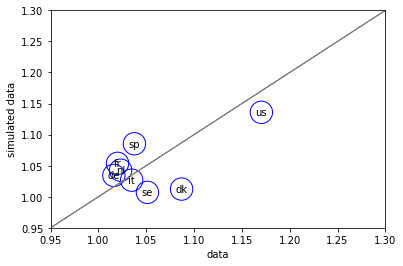

In [9]:
ssize = .15
plt.figure()
plt.scatter(momsimT.loc['g2'],momsim.loc['g2'],facecolors='none', edgecolors='b',s=500.0)
xx1 = np.amin([np.amin(momsim.loc['g2']),np.amin(momsimT.loc['g2'])])-ssize*np.amin([np.amin(momsim.loc['g2']),np.amin(momsimT.loc['g2'])])
xx2 = np.amax([np.amax(momsim.loc['g2']),np.amax(momsimT.loc['g2'])])+ssize*np.amax([np.amax(momsim.loc['g2']),np.amax(momsimT.loc['g2'])])
xx = np.linspace(xx1,xx2,20)
plt.fill_between(xx, xx-.00, xx+.00, color='grey')#, alpha='0.5')
plt.xlabel('data')
plt.ylabel('simulated data')
for x,y,z in zip(momsimT.loc['g2'],momsim.loc['g2'],countries):
    plt.annotate(z,xy=(x, y),horizontalalignment='center', verticalalignment='center')
plt.ylim([.95, 1.3])
plt.xlim([.95, 1.3])
plt.show()
#plt.savefig('../figures_JPE/grad2.eps',dpi=600)

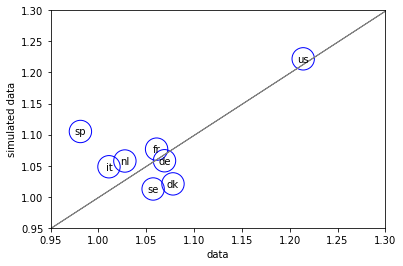

In [10]:
plt.figure()
plt.scatter(momsimT.loc['g3'],momsim.loc['g3'],facecolors='none', edgecolors='b',s=500.0)
xx1 = np.amin([np.amin(momsim.loc['g3']),np.amin(momsimT.loc['g3'])])-0.05*np.amin([np.amin(momsim.loc['g3']),np.amin(momsimT.loc['g3'])])
xx2 = np.amax([np.amax(momsim.loc['g3']),np.amax(momsimT.loc['g3'])])+0.075*np.amax([np.amax(momsim.loc['g3']),np.amax(momsimT.loc['g3'])])
xx = np.linspace(xx1,xx2,20)
plt.fill_between(xx, xx-.00, xx+.00, color='grey')#, alpha='0.5')
plt.xlabel('data')
plt.ylabel('simulated data')
for x,y,z in zip(momsimT.loc['g3'],momsim.loc['g3'],countries):
    plt.annotate(z,xy=(x, y),horizontalalignment='center', verticalalignment='center')
plt.ylim([.95, 1.3])
plt.xlim([.95, 1.3])
plt.show()
#plt.savefig('../figures_JPE/grad3.eps',dpi=600)

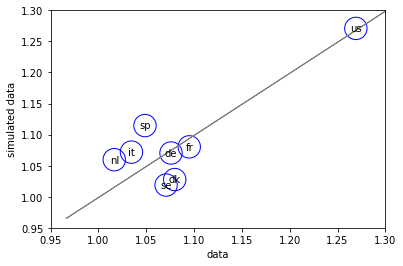

In [11]:
plt.figure()
plt.scatter(momsimT.loc['g4'],momsim.loc['g4'],facecolors='none', edgecolors='b',s=500.0)
xx1 = np.amin([np.amin(momsim.loc['g4']),np.amin(momsimT.loc['g4'])])-0.05*np.amin([np.amin(momsim.loc['g4']),np.amin(momsimT.loc['g4'])])
xx2 = np.amax([np.amax(momsim.loc['g4']),np.amax(momsimT.loc['g4'])])+0.05*np.amax([np.amax(momsim.loc['g4']),np.amax(momsimT.loc['g4'])])
xx = np.linspace(xx1,xx2,20)
plt.fill_between(xx, xx-.00, xx+.00, color='grey')#, alpha='0.5')
plt.xlabel('data')
plt.ylabel('simulated data')
for x,y,z in zip(momsimT.loc['g4'],momsim.loc['g4'],countries):
    plt.annotate(z,xy=(x, y),horizontalalignment='center', verticalalignment='center')
plt.ylim([.95, 1.3])
plt.xlim([.95, 1.3])
plt.show()
#plt.savefig('../figures_JPE/grad4.eps',dpi=600)

In [12]:
print("s")
res_spear_rho, res_spear_pv = spearmanr(momsimT.loc['s'], momsim.loc['s'])
print([res_spear_rho, res_spear_pv])
print("h")
res_spear_rho, res_spear_pv = spearmanr(momsimT.loc['h'], momsim.loc['h'])
print([res_spear_rho, res_spear_pv])
print("y")
res_spear_rho, res_spear_pv = spearmanr(momsimT.loc['y'], momsim.loc['y'])
print([res_spear_rho, res_spear_pv])

print("from good to good")
res_spear_rho, res_spear_pv = spearmanr(momsimT.loc['tgood'], momsim.loc['tgood'])
print([res_spear_rho, res_spear_pv])
print("from bad to good")
res_spear_rho, res_spear_pv = spearmanr(momsimT.loc['tbad'], momsim.loc['tbad'])
print([res_spear_rho, res_spear_pv])

print("gradient g2")
res_spear_rho, res_spear_pv = spearmanr(momsimT.loc['g2'], momsim.loc['g2'])
print([res_spear_rho, res_spear_pv])
print("gradient g3")
res_spear_rho, res_spear_pv = spearmanr(momsimT.loc['g3'], momsim.loc['g3'])
print([res_spear_rho, res_spear_pv])
print("gradient g4")
res_spear_rho, res_spear_pv = spearmanr(momsimT.loc['g4'], momsim.loc['g4'])
print([res_spear_rho, res_spear_pv])

s
[1.0, 0.0]
h
[0.7142857142857144, 0.04652823228416724]
y
[1.0, 0.0]
from good to good
[0.5714285714285715, 0.1389599571607067]
from bad to good
[0.5000000000000001, 0.20703124999999997]
gradient g2
[0.0, 1.0]
gradient g3
[0.11904761904761905, 0.7788857260523797]
gradient g4
[0.3333333333333334, 0.4197530864197531]


## Additional information 

### Price gaps

In [13]:
# pop seize 2015
weight_co = np.array([81174000, 5659715, 66352469, 60795612, 16900726, 9747355, 46439864])
# basic mean
bm_price = np.mean(pars.loc['p',countries[0:7]])
# mean with country weight
wm_price = np.sum(weight_co*pars.loc['p',countries[0:7]]/np.sum(weight_co))
print(bm_price,wm_price)

0.7450567946438661 0.7137430518130534


### TFP gaps

In [14]:
# basic mean
bm_tfp = np.mean(pars.loc['tfp',countries[0:7]])
# mean with country weight
wm_tfp = np.sum(weight_co*pars.loc['tfp',countries[0:7]]/np.sum(weight_co))
print(bm_tfp,wm_tfp)

0.9124184429499074 0.867623628988201


In [15]:
from pandas import read_excel
file_name = 'xlsx_files/TFP_data.xlsx' # name of your excel file
my_sheet  = 'data2'    # sheet name
data_tfp_ts   = read_excel(file_name, sheet_name = my_sheet)

/Users/flangot/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  after removing the cwd from sys.path.


In [16]:
print("Groningen")
res_spear_rho, res_spear_pv = spearmanr(pars.loc['tfp',:], data_tfp_ts.loc[:,'Groningen 1997'])
print([res_spear_rho, res_spear_pv])
print("Banque de France")
res_spear_rho, res_spear_pv = spearmanr(pars.loc['tfp',:], data_tfp_ts.loc[:,'Banque de France'])
print([res_spear_rho, res_spear_pv])

Groningen
[0.9047619047619048, 0.0020082755054294677]
Banque de France
[0.7619047619047621, 0.028004939153071794]


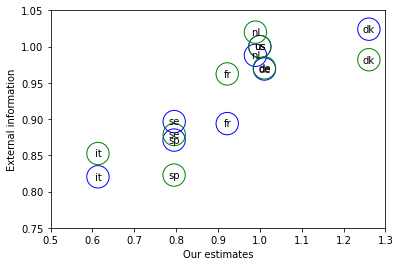

In [17]:
plt.figure()
plt.scatter(pars.loc['tfp',:],data_tfp_ts.loc[:,'Groningen 1997'],facecolors='none', edgecolors='b',s=500.0)
plt.scatter(pars.loc['tfp',:],data_tfp_ts.loc[:,'Banque de France'],facecolors='none', edgecolors='g',s=500.0)
plt.xlim(0.5,1.3)
plt.ylim(0.75,1.05)
plt.xlabel('Our estimates')
plt.ylabel('External information')
for x,y,z in zip(pars.loc['tfp',:],data_tfp_ts.loc[:,'Groningen 1997'],countries):
    plt.annotate(z,xy=(x, y),horizontalalignment='center', verticalalignment='center')
for x,y,z in zip(pars.loc['tfp',:],data_tfp_ts.loc[:,'Banque de France'],countries):
    plt.annotate(z,xy=(x, y),horizontalalignment='center', verticalalignment='center')
#plt.savefig('../figures_JPE/tfp_vs_data.eps',dpi=600)

In [18]:
print("s")
res_spear_rho, res_spear_pv = spearmanr(momsimT.loc['s'], momsim.loc['s'])
print([res_spear_rho, res_spear_pv])
print("h")
res_spear_rho, res_spear_pv = spearmanr(momsimT.loc['h'], momsim.loc['h'])
print([res_spear_rho, res_spear_pv])
print("y")
res_spear_rho, res_spear_pv = spearmanr(momsimT.loc['y'], momsim.loc['y'])
print([res_spear_rho, res_spear_pv])

print("from good to good")
res_spear_rho, res_spear_pv = spearmanr(momsimT.loc['tgood'], momsim.loc['tgood'])
print([res_spear_rho, res_spear_pv])
print("from bad to good")
res_spear_rho, res_spear_pv = spearmanr(momsimT.loc['tbad'], momsim.loc['tbad'])
print([res_spear_rho, res_spear_pv])

print("gradient g2")
res_spear_rho, res_spear_pv = spearmanr(momsimT.loc['g2'], momsim.loc['g2'])
print([res_spear_rho, res_spear_pv])
print("gradient g3")
res_spear_rho, res_spear_pv = spearmanr(momsimT.loc['g3'], momsim.loc['g3'])
print([res_spear_rho, res_spear_pv])
print("gradient g4")
res_spear_rho, res_spear_pv = spearmanr(momsimT.loc['g4'], momsim.loc['g4'])
print([res_spear_rho, res_spear_pv])

s
[1.0, 0.0]
h
[0.7142857142857144, 0.04652823228416724]
y
[1.0, 0.0]
from good to good
[0.5714285714285715, 0.1389599571607067]
from bad to good
[0.5000000000000001, 0.20703124999999997]
gradient g2
[0.0, 1.0]
gradient g3
[0.11904761904761905, 0.7788857260523797]
gradient g4
[0.3333333333333334, 0.4197530864197531]
